In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
from PIL import Image
from torchvision import models, transforms

In [24]:
vgg = models.vgg11(pretrained = True).features

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [23]:
for parameter in vgg.parameters():
    parameter.requires_grad_(False)
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace)
  (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace)
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17)

In [9]:
def features(image, model):
    x = image
    layers = ['0', '3', '8', '13', '18']
    features = []
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features.append(x)
    return features

In [17]:
def grammatrix(image):
    b,d,h,w = image.size()
    image = image.view(d, h*w)
    gram = torch.mm(image, image.t())
    return gram

In [11]:
def Open(path, shape = 500):
    input_transform = transforms.Compose([transforms.Resize((shape, shape)),
                                                           transforms.ToTensor(),
                                                           transforms.Normalize((0.485,0.456,0.406),
                                                                               (0.229,0.224,0.225))
                                                           ])
    image = Image.open(path).convert('RGB')
    image = input_transform(image).unsqueeze(0)
    return image

In [20]:
def convert(image):
    image = image.squeeze().permute(1,2,0).detach().to("cpu").numpy()
    image = image * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    return (image*255).astype(np.uint8)

In [25]:
contentimage = Open(os.getcwd()+'/me1.jpg').to(device)
styleimage = Open(os.getcwd()+'/paint.jpg').to(device)

In [26]:
content = features(contentimage, vgg)
style = [grammatrix(feature) for feature in features(styleimage, vgg)]

In [27]:
targetimage = contentimage.clone().requires_grad_(True).to(device)

In [28]:
optimizer = torch.optim.Adam([targetimage], lr = 0.003)

In [29]:
alpha = 1
beta = 1000
styleweights = [1e3/n**2 for n in [64,128,256,512,512]]

In [30]:
styleweights

[0.244140625,
 0.06103515625,
 0.0152587890625,
 0.003814697265625,
 0.003814697265625]

In [38]:
epochs = 1
loss = []
for epoch in range(epochs):
    targetcontent = features(targetimage, vgg)
    targetstyle = [grammatrix(feature) for feature in features(targetimage, vgg)]
    
    styleloss = 0.0
    contentloss = torch.mean((targetcontent[1]-content[1])**2)
    for i in range(5):
        _,d,h,w = targetcontent[i].shape
        styleloss += styleweights[i]*((torch.mean(targetstyle[i]-style[i])**2)/(d*h*w))
    
    total_loss = alpha*contentloss + beta*styleloss
    loss.append(total_loss.item())
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

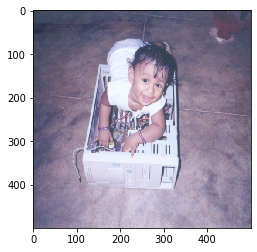

In [36]:
import matplotlib.pyplot as plt
plt.imshow(convert(targetimage))
plt.show()